In [ ]:
# imports
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import numpy as np 
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train, batch_size=128,
                                          shuffle=True, num_workers=2)
test = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test, batch_size=16,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
# ALL-CNN from github
class View(nn.Module):
    def __init__(self,o):
        super().__init__()
        self.o = o

    def forward(self,x):
        return x.view(-1, self.o)
    
class allcnn_t(nn.Module):
    def __init__(self, c1=96, c2= 192):
        super().__init__()
        d = 0.5

        def convbn(ci,co,ksz,s=1,pz=0):
            return nn.Sequential(
                nn.Conv2d(ci,co,ksz,stride=s,padding=pz),
                nn.ReLU(True),
                nn.BatchNorm2d(co))

        self.m = nn.Sequential(
            nn.Dropout(0.2),
            convbn(3,c1,3,1,1),
            convbn(c1,c1,3,1,1),
            convbn(c1,c1,3,2,1),
            nn.Dropout(d),
            convbn(c1,c2,3,1,1),
            convbn(c2,c2,3,1,1),
            convbn(c2,c2,3,2,1),
            nn.Dropout(d),
            convbn(c2,c2,3,1,1),
            convbn(c2,c2,3,1,1),
            convbn(c2,10,1,1),
            nn.AvgPool2d(8),
            View(10))

        print('Num parameters: ', sum([p.numel() for p in self.m.parameters()]))

    def forward(self, x):
        return self.m(x)

(b)

In [ ]:
# fix all hyper-parameters:
# dropout = 0.5, momentum: rho = 0.9, weight decay: wd = 0.001
criterion = nn.CrossEntropyLoss()
eta_0 = 1e-5
eta = eta_0
etas = []
net = allcnn_t()
all_loss = []
n_iter = 100
t = 0
optimizer = optim.SGD(net.parameters(), lr=eta_0, momentum=0.9, weight_decay=0.001)

Num parameters:  1667166


In [ ]:
for i, data in enumerate(train_loader, 0): 
    input, label = data
    optimizer.zero_grad()
    output = net(input)
    loss = criterion(output, label)
    loss.backward()
    eta = 1.1*(eta)
    etas.append(eta)
    optimizer = optim.SGD(net.parameters(), lr=eta, momentum=0.9, weight_decay=0.001)
    optimizer.step()
    t += 1
    loss_t = loss.item()
    all_loss.append(loss_t) 
    if t == n_iter: 
      break 
    else: 
      continue

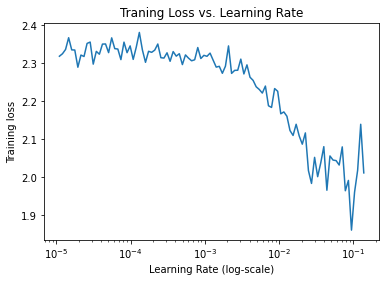

In [ ]:
plt.semilogx(np.array(etas), np.array(all_loss))
plt.ylabel('Training loss')
plt.xlabel('Learning Rate (log-scale)')
plt.title("Traning Loss vs. Learning Rate")
plt.savefig('2(b).pdf')

In [ ]:
# find the minimum
min_idx = np.argmin(np.array(all_loss))
eta_star = etas[min_idx]
print("Learning rate with the minimum loss is {}".format(eta_star))

Learning rate with the minimum loss is 0.09412343651268613


(c)

In [ ]:
def train(net, optimizer, criterion, train_loader, test_loader, epochs):
    model = net.to(device)
    steps = len(train_loader)
    train_loss, val_loss = [], []
    T = epochs*391
    T0 = T/5
    lr_max = eta_star
    lr_list = []
    loss_list = []

    for epoch in range(epochs):
      model.train()
      for i, (data, labels) in enumerate(train_loader):
        data = data.to(device)
        labels = labels.to(device)
        outputs = model(data)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        t = epoch*391+i
        if t <= T0:
          for g in optimizer.param_groups: 
            g['lr'] = 1e-4 + t/T0*lr_max
            lr_list.append(g['lr'])
        else:
          for g in optimizer.param_groups:
            g['lr'] = lr_max * np.cos(np.pi/2*(t-T0)/(T-T0)) + 1e-6
            lr_list.append(g['lr'])
        loss_list.append(loss.item())

        optimizer.step()
        if (epoch*391+i)%100 == 0:
          print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(epoch+1, epochs, i+1, steps, loss.item()))
          train_loss.append(np.mean(loss_list))
          loss_list = []

          model.eval()
          with torch.no_grad():
            correct = 0
            total = 0
            for i, (data, labels) in enumerate(test_loader):
                data = data.to(device)
                labels = labels.to(device)
                outputs = model(data)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

          print('Validation loss of the network on the test data: {} %'.format(100 * correct / total))
          val_loss.append(100 * correct / total)
          model.train()

    return train_loss, val_loss, lr_list

In [ ]:
model = allcnn_t().to(device)
epochs = 100
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-5, momentum=0.9, weight_decay=1e-3)
train_loss, val_loss, lr_list = train(model, optimizer, criterion, train_loader, test_loader, epochs)

Num parameters:  1667166
Epoch [1/100], Step [1/391], Loss: 2.3347
Validation loss of the network on the test data: 10.0 %
Epoch [1/100], Step [101/391], Loss: 1.9934
Validation loss of the network on the test data: 19.19 %
Epoch [1/100], Step [201/391], Loss: 1.8023
Validation loss of the network on the test data: 23.27 %
Epoch [1/100], Step [301/391], Loss: 1.6964
Validation loss of the network on the test data: 36.4 %
Epoch [2/100], Step [10/391], Loss: 1.5162
Validation loss of the network on the test data: 37.14 %
Epoch [2/100], Step [110/391], Loss: 1.4422
Validation loss of the network on the test data: 43.85 %
Epoch [2/100], Step [210/391], Loss: 1.4151
Validation loss of the network on the test data: 44.74 %
Epoch [2/100], Step [310/391], Loss: 1.2439
Validation loss of the network on the test data: 48.67 %
Epoch [3/100], Step [19/391], Loss: 1.1613
Validation loss of the network on the test data: 48.31 %
Epoch [3/100], Step [119/391], Loss: 1.1387
Validation loss of the netwo

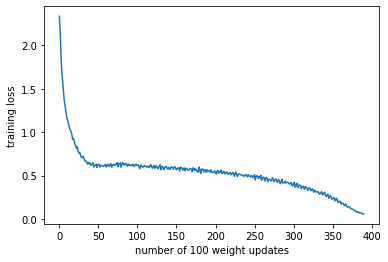

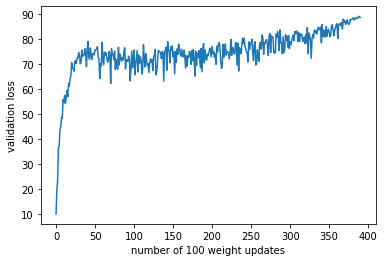

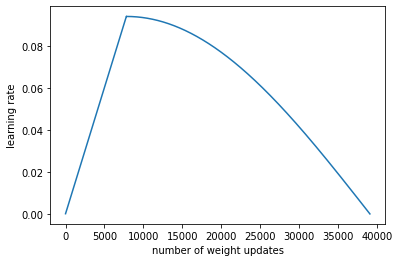

In [ ]:
plt.figure()
plt.plot(train_loss); plt.ylabel('training loss'); plt.xlabel('number of 100 weight updates')
plt.figure()
plt.plot(val_loss); plt.ylabel('validation loss'); plt.xlabel('number of 100 weight updates')
plt.figure()
plt.plot(lr_list); plt.ylabel('learning rate'); plt.xlabel('number of weight updates')
plt.show()
plt.savefig('2c.pdf')

(d)

In [ ]:
# (i)
def train(net, criterion, train_loader, test_loader, epochs, lr_max, momentum):
    model = net.to(device)
    T = epochs*391
    T0 = T/5
    optimizer = optim.SGD(model.parameters(), lr=1e-5, momentum=momentum, weight_decay=1e-3)

    for epoch in range(epochs):
      model.train()
      for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        t = epoch*391+i
        if t <= T0:
          for g in optimizer.param_groups:
            g['lr'] = 1e-4 + t/T0*lr_max
        else:
          for g in optimizer.param_groups:
            g['lr'] = lr_max * np.cos(np.pi/2*(t-T0)/(T-T0)) + 1e-6

        optimizer.step()
    model.eval()
    with torch.no_grad():
      correct = 0
      total = 0
      for i, (images, labels) in enumerate(test_loader):
          images = images.to(device)
          labels = labels.to(device)
          outputs = model(images)
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()

    print('Validation error of the network on the test images: {} %'.format((1-correct / total)*100))

    return


In [ ]:
epochs = 50
lr_max = eta_star
criterion = nn.CrossEntropyLoss()
model = allcnn_t().to(device)
train(model, criterion, train_loader, test_loader, epochs, lr_max, momentum=0.9)

Num parameters:  1667166
Validation error of the network on the test images: 11.09 %


In [ ]:
# (ii)
model = allcnn_t().to(device)
train(model, criterion, train_loader, test_loader, epochs, lr_max*5, momentum=0.5)

Num parameters:  1667166
Validation error of the network on the test images: 11.119999999999997 %


In [ ]:
# (iii)
model = allcnn_t().to(device)
train(model, criterion, train_loader, test_loader, epochs, lr_max, momentum=0.5)

Num parameters:  1667166
Validation error of the network on the test images: 12.170000000000003 %
